In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [3]:
structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [100,200,300,400,500,600,700,800,900,1000]
margins_to_sample = [500]

surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]

surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

labels_to_sample = structures_to_sample + \
surround_positive_labels_to_sample + surround_noclass_labels_to_sample + \
['noclass']

# Load test dataset

In [6]:
test_dataset_id = 92

In [7]:
# test_features, test_addresses = load_datasets([test_dataset_id], labels_to_sample=labels_to_sample)
test_features, test_addresses = load_datasets([test_dataset_id], labels_to_sample=labels_to_sample,
                                             clf_rootdir=CELL_FEATURES_CLF_ROOTDIR)

In [8]:
assert set(test_addresses.keys()) == set(test_features.keys()), \
'Test features and test addresses are not consistent.'

In [9]:
labels_found = test_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

# Load pre-computed svm classifiers

In [10]:
classifier_id = 95

In [11]:
# setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))
setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [12]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_to_ec2(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/sp5_clf_setting_95.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_95/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_95/classifiers/sp5_clf_setting_95.dump /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/sp5_clf_setting_95.dump


Child returned 0
Child returned 1
0.36 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/outerContour_clf_setting_95.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_95/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_95/classifiers/outerContour_clf_setting_95.dump /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/outerContour_clf_setting_95.dump


Child returned 1
0.33 seconds.
Classifier for outerContour is not found.


# Generate Evaluation Results

In [13]:
eval_dir = create_if_not_exists(os.path.join(setting_dir, 'eval'))

# Compute x vs. surround accuracy

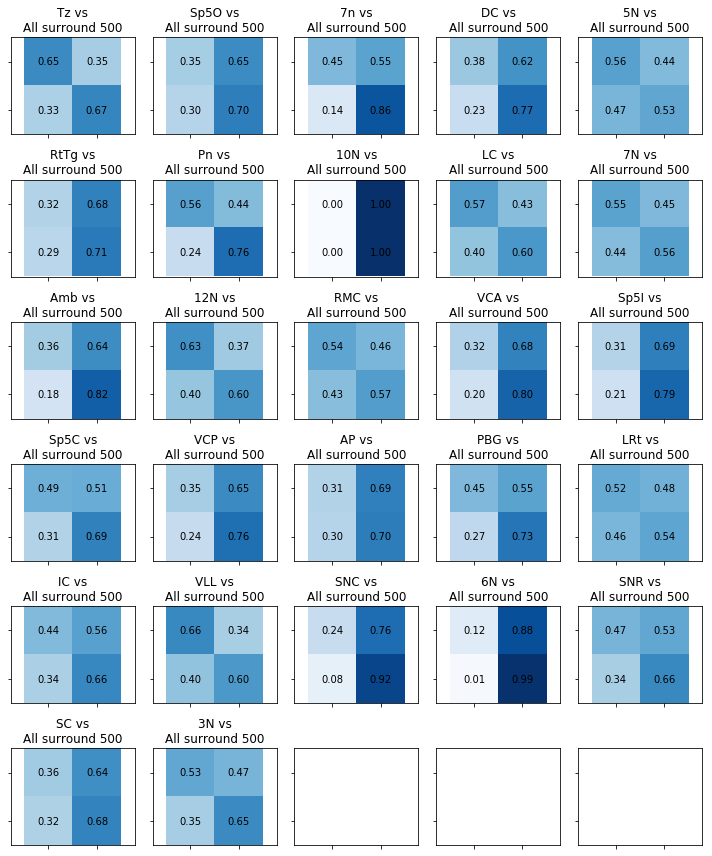

In [14]:
# Compute surround accuracy

margin = 500

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
    n_neg = len(features_neg)

    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]

    if structure not in clf_allClasses:
        sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
        continue
        
    clf = clf_allClasses[structure]

    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)

    plot_confusion_matrix(cm, title='%(structure)s vs\nAll surround %(margin)d'% {'structure':structure, 'margin':margin},
                          labels=['',''], xlabel='', ylabel='',
                         axis=axes[i])

    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[structure] = acc
        
plt.tight_layout()

In [15]:
print [' '.join([n, '%.2f'%a]) for n, a in sorted(acc_all_structures.items())]

['10N 0.99', '12N 0.62', '3N 0.59', '5N 0.54', '6N 0.88', '7N 0.56', '7n 0.80', 'AP 0.53', 'Amb 0.66', 'DC 0.66', 'IC 0.59', 'LC 0.59', 'LRt 0.53', 'PBG 0.67', 'Pn 0.67', 'RMC 0.55', 'RtTg 0.56', 'SC 0.57', 'SNC 0.76', 'SNR 0.59', 'Sp5C 0.61', 'Sp5I 0.65', 'Sp5O 0.57', 'Tz 0.66', 'VCA 0.67', 'VCP 0.65', 'VLL 0.63']


In [16]:
structures_sorted_by_size = ['4N', '6N', 'Amb', 'PBG', '10N', 'AP', '3N', 'LC', 'SNC', 'Tz', '7n', 'RMC', '5N', 'VCP', '12N', 'LRt', '7N', 'VCA', 'VLL', 'DC', 'Sp5O', 'Sp5I', 'Pn', 'RtTg', 'SNR', 'Sp5C', 'IC', 'SC']

In [17]:
x =[[s] if s in singular_structures else [convert_to_left_name(s), convert_to_right_name(s)] for s in structures_sorted_by_size]
structures_sided_sorted_by_size = [j for i in x for j in i ]
print structures_sided_sorted_by_size

['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']


In [18]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.6, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

KeyError: '4N'

In [19]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.642710559306


# Compute surround accuracy (margin = 200)

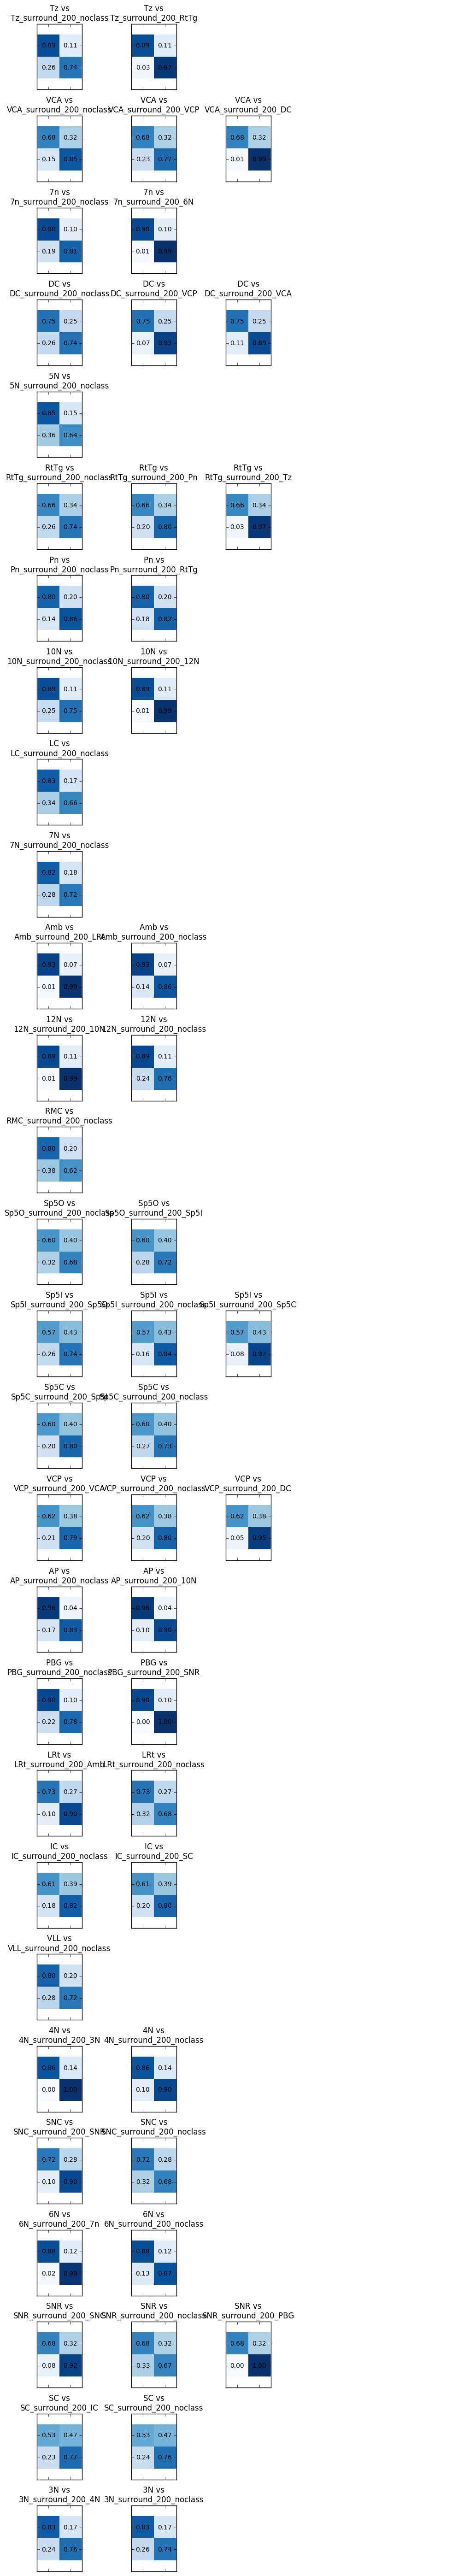

In [31]:
# Compute surround accuracy (margin = 200)

margin = 200
acc_all_pairs = {}
example_number_all_pairs = {}

ncols = 5
nrows = len(structures_found)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
# axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    for j, neg_class in enumerate(neg_classes):

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)

        plot_confusion_matrix(cm, title='%(structure)s vs\n%(neg_class)s'% {'structure':structure, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=False)
        acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
        acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc
        example_number_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = n_pos + n_neg
        
    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [163]:
surround_cm_plot_fp = os.path.join(eval_dir, 'surround_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [33]:
print np.sum([example_number_all_pairs[pair]*acc for pair, acc in acc_all_pairs.iteritems()])/np.sum(example_number_all_pairs.values())

0.77514253233097619

In [20]:
print np.mean(acc_all_pairs.values())

0.781163498179


In [72]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('SC vs SC_surround_200_IC', 0.54535345166832483),
 ('IC vs IC_surround_200_SC', 0.63378344327912872),
 ('10N vs 10N_surround_200_noclass', 0.66050820739068417),
 ('SNC vs SNC_surround_200_noclass', 0.6633200091275756),
 ('RtTg vs RtTg_surround_200_noclass', 0.6714797206147668),
 ('6N vs 6N_surround_200_noclass', 0.68985533506809538),
 ('VCP vs VCP_surround_200_noclass', 0.69551525152803007),
 ('SNR vs SNR_surround_200_noclass', 0.69812509104994369),
 ('LC vs LC_surround_200_noclass', 0.69853481782094007),
 ('Tz vs Tz_surround_200_noclass', 0.70507607073460576),
 ('SC vs SC_surround_200_noclass', 0.71317376942676081),
 ('7N vs 7N_surround_200_noclass', 0.71696350213779547),
 ('12N vs 12N_surround_200_noclass', 0.72143003058763044),
 ('VCP vs VCP_surround_200_VCA', 0.73092031183557071),
 ('Pn vs Pn_surround_200_RtTg', 0.73416013205951769),
 ('Sp5C vs Sp5C_surround_200_noclass', 0.73950306731435578),
 ('RtTg vs RtTg_surround_200_Pn', 0.74218217411311727),
 ('VLL vs VLL_surround_200_nocl

# Compute surround accuracy for different margins

In [21]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in margins_to_sample:

    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, structure in enumerate(structures_found):

        features_pos = test_features[structure]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]
        
        neg_classes = list(set(neg_classes) & set(labels_found))

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]

            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc

    acc_all_margins[margin] = acc_all_pairs

margin = 200
margin = 500


In [22]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

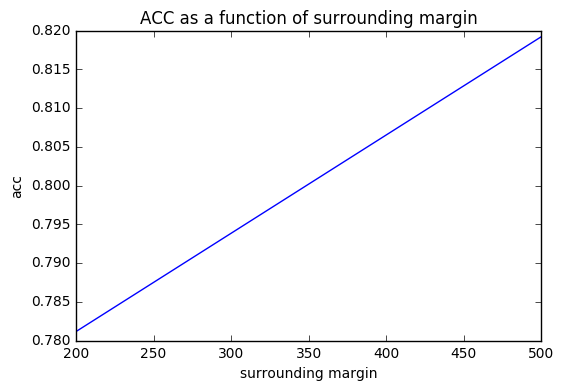

In [23]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute x vs. all negative accuracy

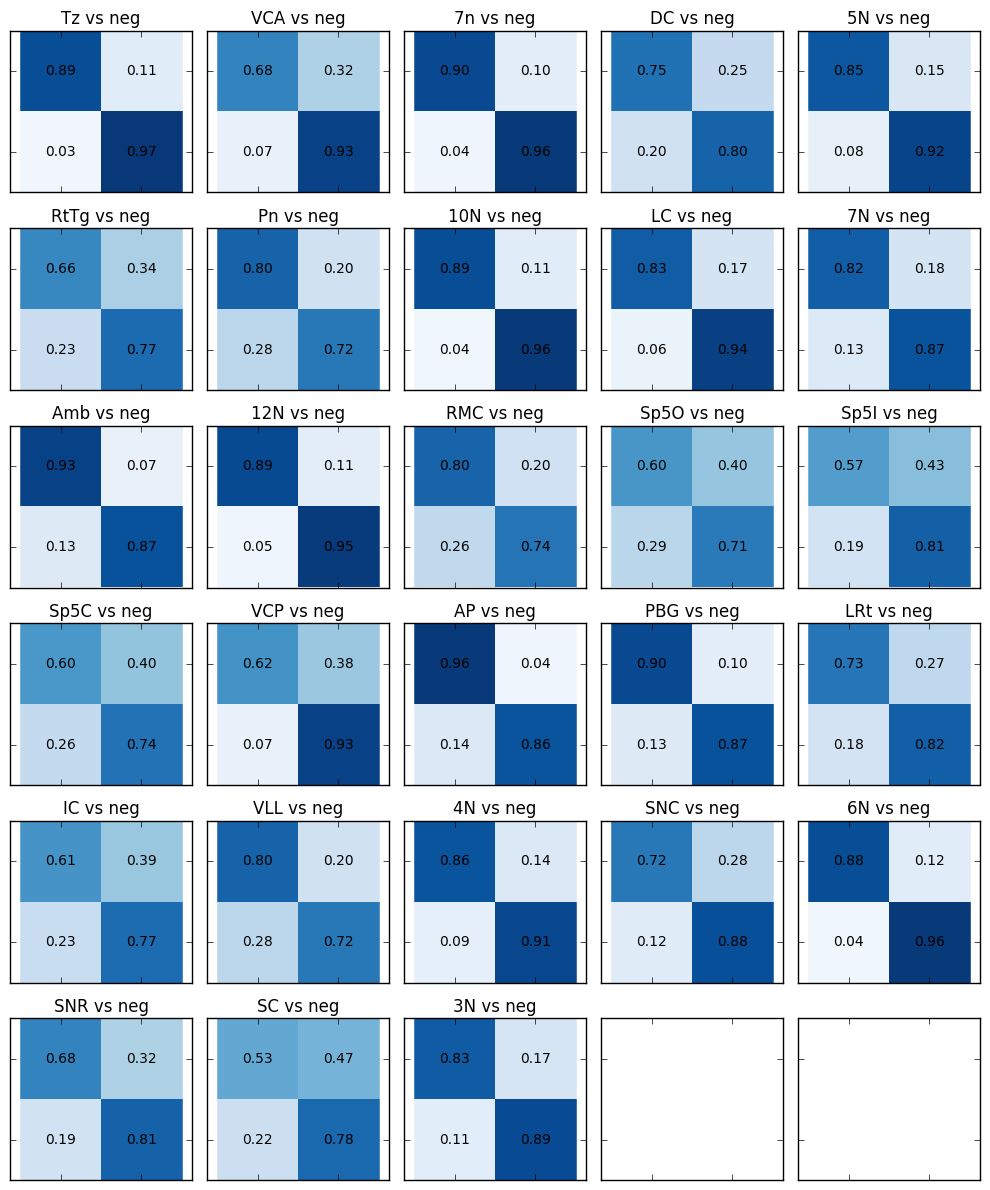

In [88]:
# Compute testing accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features[structure + '_negative']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs neg'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()

print 'test accuracy:', np.mean(acc_all_structures.values())

# single_vs_negative_cm_plot_fp = os.path.join(eval_dir, 'single_vs_negative_cm_setting_%d_testset_%d.png' % (setting, dataset))
# fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

# Compute X with all surround

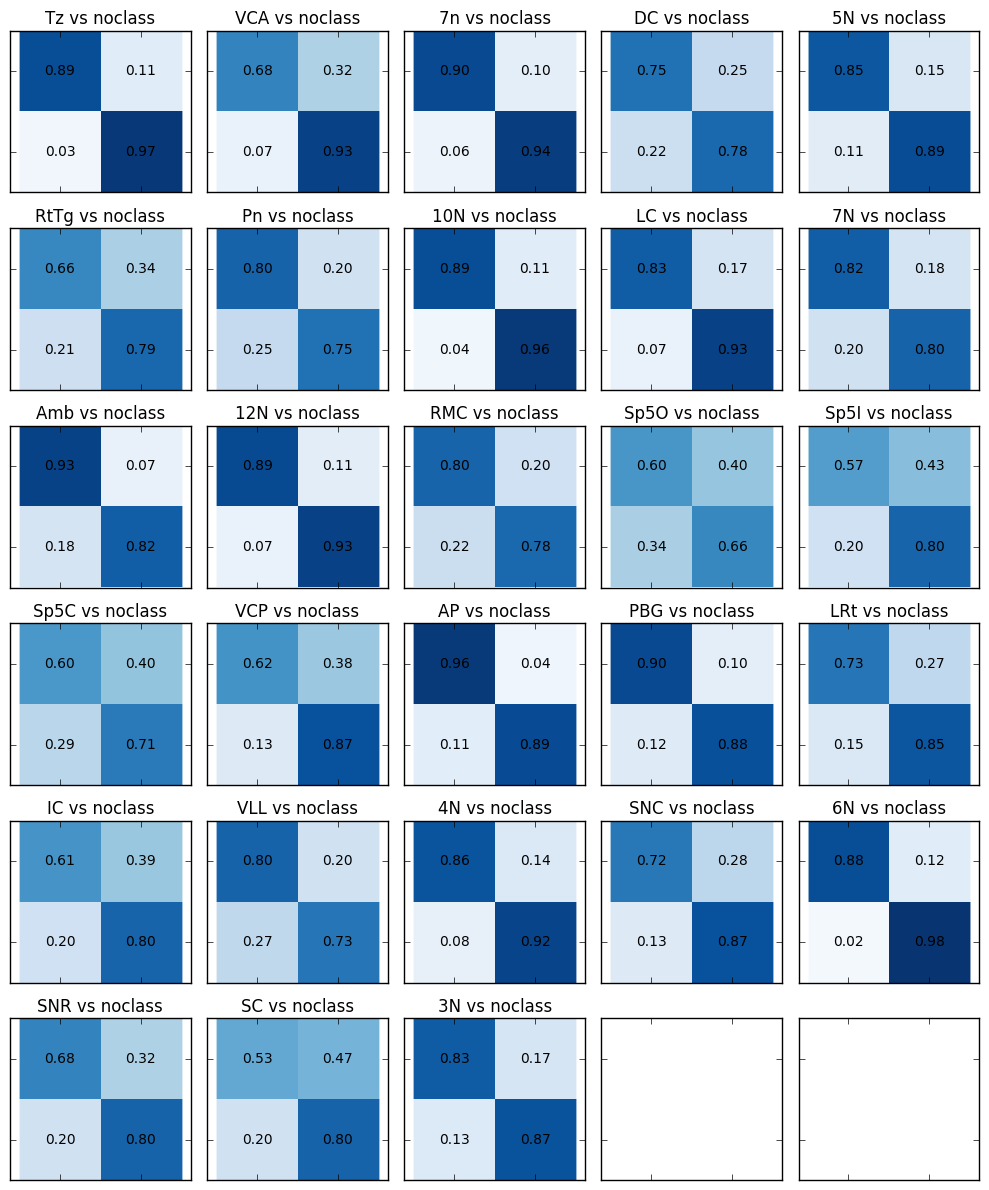

In [15]:
# Compute x vs. noclass accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features['noclass']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs noclass'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()


print 'test accuracy:', np.mean(acc_all_structures.values())

# single_vs_noclass_cm_plot_fp = os.path.join(eval_dir, 'single_vs_noclass_cm_setting_%d_testset_%d.png' % (setting, dataset))
# fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute pairwise accuracy

In [76]:
# Compute pairwise accuracy

n_structures = len(structures_found)
pairwise_cm = np.zeros((n_structures, n_structures))

# for i, label in enumerate(structures):
# axes_id = 0
for i, structure in enumerate(structures_found):
    
#     print i, structure
    
    features_pos = test_features[structure]
    n_pos = len(features_pos)
        
    for j, structure2 in enumerate(structures_found):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
#         print 'comparing with', j, structure2
        
        features_neg = test_features[structure2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

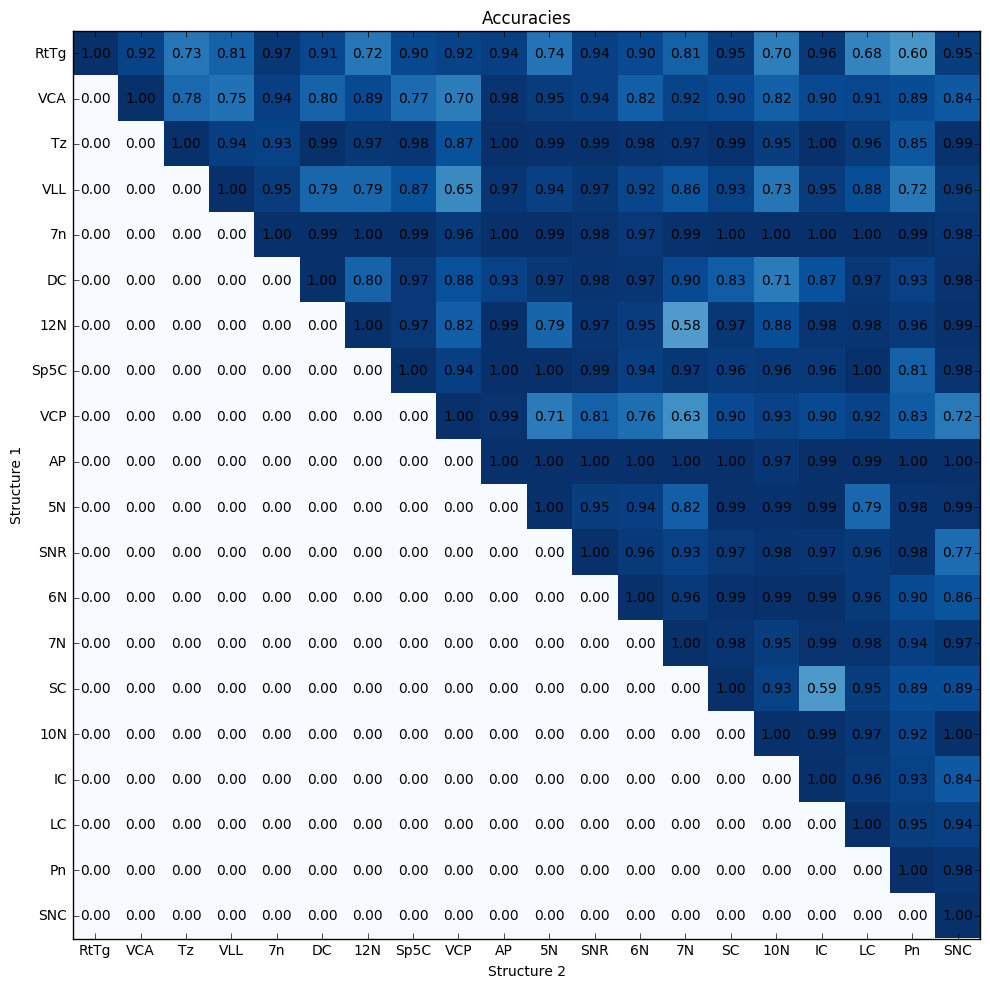

In [77]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=structures_found,
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [78]:
pariwise_cm_plot_fp = os.path.join(eval_dir, 'pairwise_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')